# A sandbox to test code, post ideas, etc. 

#### Libraries

In [36]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


#from sklearn's...
from sklearn.feature_extraction.text import CountVectorizer #Convert a collection of text documents to a matrix of token counts.
from sklearn.feature_extraction.text import TfidfTransformer #Transform a count matrix to a normalized tf or tf-idf representation
from sklearn.feature_extraction.text import TfidfVectorizer #Convert a collection of raw documents to a matrix of TF-IDF features
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.naive_bayes import ComplementNB
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import VotingClassifier
import random


*We have three datasets we are using; training (**train_ds**), testing (**test_ds**), and testing labels (**test_labels_ds**)*

#### Load training and test dataframes from file; preprocessing completed in 'text_preprocessing' notebook

In [2]:
file_object = open('clean_data1.p', 'rb')
clean_data = pickle.load(file_object)
train_df = clean_data[0]
test_df = clean_data[1]
#test_lab = clean_data[2]


In [3]:
train_df.head(3)

,comment_text,non_toxic,toxic,severe_toxic,toxicity_level
81898,sorry break unsourced film plot much error uns...,1,0,0,1
139339,criticism criticism doesnt belong title busine...,1,0,0,1
67989,article cant remember password jim bakken im f...,1,0,0,1


In [4]:
train_df.shape

(4398, 5)

In [5]:
print(train_df[['toxicity_level']].value_counts())

toxicity_level
3                 1595
1                 1433
2                 1370
dtype: int64


In [6]:
test_df.head(3)

,comment_text,non_toxic,toxic,severe_toxic,toxicity_level
152094,open shut case httpwwwdailymailcouknewsarticle...,1.0,0.0,0.0,1
29806,richard k clearly axe grind,1.0,0.0,0.0,1
24494,relevant manual style require title list defin...,1.0,0.0,0.0,1


In [7]:
train_df['comment_text'][0:500]

81898     sorry break unsourced film plot much error uns...
139339    criticism criticism doesnt belong title busine...
67989     article cant remember password jim bakken im f...
12648     prospective mega man music article sure im wil...
90654     seem fine didnt realize much check ref article...
                                ...                        
13146     useredited encyclopedia shut access wikipedia ...
48442     armenian source v turkish source well would ap...
158705    since point make article intro subsection page...
56725                                         back scythian
65478     neither resort insult put word opponent mouth ...
Name: comment_text, Length: 500, dtype: object

## Subsets of data

Subset1: Full dataset

In [8]:
#subset of training data
train_df_subset1 = train_df['comment_text']
train_lab_subset1 = train_df['toxicity_level']

#subset of testing data
test_df_subset1 = test_df['comment_text']
test_lab_subset1 = test_df['toxicity_level']

Subset2: Create a subsample of data for quickened runtime with 500 samples

In [9]:
#subset of training data
train_df_subset2 = train_df['comment_text'][0:500]
train_lab_subset2 = train_df['toxicity_level'][0:500]

#subset of testing data
test_df_subset2 = test_df['comment_text'][0:500]
test_lab_subset2 = test_df['toxicity_level'][0:500]

Subset3: Create a subsample of data for quickened run time with toxcity_level as label

In [22]:
'''
#subset of testing data; removed the id column
subset3 = train_df.sample(n = 1000, random_state= 123)
train_df_subset3 = subset3['comment_text']
train_lab_subset3 = subset3['toxicity_level']

#subset of testing data; removed the id column
subset3_test = test_df.sample(n = 1000, random_state= 123)
subset3_test_lab = test_lab.sample(n = 1000, random_state= 123)
train_df_subset3 = subset3_test['comment_text']
train_lab_subset3 = subset3_test_lab['toxicity_level']
'''

In [23]:
#train_df_subset3.shape

(1000,)

### Sample how we did it in homework just on 5 comments as corpus

##### Get term count matrix along with terms array

In [10]:
corpus = train_df['comment_text']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
terms = vectorizer.get_feature_names_out()
terms

array(['aaa', 'aadam', 'aand', ..., '関係ない', '青山内科', '번역'], dtype=object)

In [11]:
X = pd.DataFrame(X.toarray())
X

,0,1,2,3,4,5,6,7,8,9,...,14832,14833,14834,14835,14836,14837,14838,14839,14840,14841
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4395,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Get TFIDF matrix as dataframe

In [12]:
tfidfTransform = TfidfTransformer()
X_tfidf = tfidfTransform.fit_transform(X)
X_tfidf = pd.DataFrame(X_tfidf.toarray())
X_tfidf

,0,1,2,3,4,5,6,7,8,9,...,14832,14833,14834,14835,14836,14837,14838,14839,14840,14841
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
DT_tfidf = X_tfidf.T
DT_tfidf = np.array(DT_tfidf)
DT_tfidf.shape

(14842, 4398)

In [14]:
pca = PCA()
DTtrans = pca.fit(DT_tfidf).transform(DT_tfidf)
varPercentage = pca.explained_variance_ratio_*100
print(varPercentage)

[2.39033825e+00 1.03766097e+00 7.97501757e-01 ... 2.12071299e-34
 6.49497044e-35 1.15076561e-35]


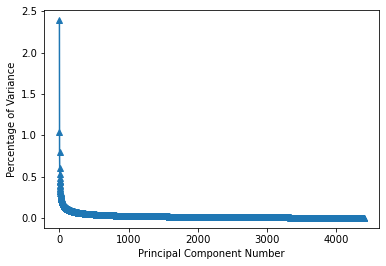

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1, 4399), varPercentage, marker='^')
plt.xlabel('Principal Component Number')
plt.ylabel('Percentage of Variance')
plt.show()

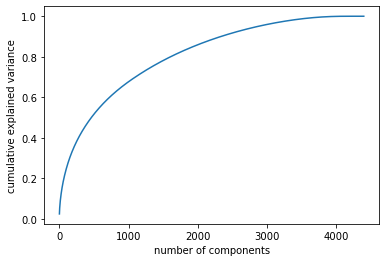

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Using Pipelines for analysis

In [ ]:
#ComplementNB()
'''
Typically out performs Multinomial Naive Bayes with text data. Hyperparameter to tune is alpha (Laplace smoothing). 
The default = 1 (new tokens in the test data that were not in the training data are ignored). A large alpha pushes the token to 50/50
which is not useful information.
If our comments were longer text we could use the second normalization.
'''


#### Parameter dictionaries


* max_df: ignore terms that have a document frquency strictly higher than the given threshold  
* min_df: ignore terms that have a document frequency strictly lower than the given threshold

Naive Bayes

In [17]:
# Input is a selected combination from Stage 1(Preprocessing) & Stage 2(Sampling).

# Tuning Stage 4 unable to complete with Naive Bayes as cannot pass negative values to NB

# Stage 3 hyperparameter tunning

# Hyperparameter tunning

# parameters for CountVectorizer()
countvect_params = {
    'count__min_df': [1, 3, 10], 
    'count__max_df': [0.6, 0.8, 0.9]
    
}

# parameters for TfidfVectorizer()
vectorizer_params = {
    'vect__min_df': [1, 3, 10], 
    'vect__max_df': [0.6, 0.8, 0.9],
    'vect__norm': ['l1','l2']
}

# parameters for Complimentary Naive Bayes()
compNB_params = {
    'alpha' : [1, 10, 100]
}

KNN

In [18]:
# Input is a selected combination from Stage 1(Preprocessing) & Stage 2(Sampling).
# Tuning Stage 4 (best number of dimensions occurs after Stage 1 & 2)

# Stage 3 & 4 tunning and hyperparameter tunning

#Hyperparameter tunning

#Token 
min_DF = [1, 3, 10]
max_DF = [0.6, 0.8, 0.9]
#norm = ['l1','l2']

#Dimensionality Recudtion
n_components = [115]

#Classifer 
n_neighbors = [5, 10]

#Parameter dictionary for KNN Pipeline
KNN_params =[
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': ['passthrough'],
        'clf__n_neighbors': n_neighbors
    },
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': n_components,
        'clf__n_neighbors': n_neighbors
    }
]

Rocchio

In [19]:
# Input is a selected combination from Stage 1(Preprocessing) & Stage 2(Sampling).
# Tuning Stage 4 (best number of dimensions occurs after Stage 1 & 2)

# Stage 3 & 4 tunning and hyperparameter tunning

#Hyperparameter tunning

#Token 
min_DF = [1, 3, 10]
max_DF = [0.6, 0.8, 0.9]
#norm = ['l1','l2']

#Dimensionality Recudtion
n_components = [115]

#Classifer 
metric = ['euclidian', 'cosine']
classes = ['1','2','3']
#Parameter dictionary for KNN Pipeline
Rocchio_params =[
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': ['passthrough'],
        'clf__metric': metric
    },
    {
        'token_value': [CountVectorizer(), TfidfVectorizer()],
        'token_value__min_df': min_DF,
        'token_value__max_df': max_DF,
        'reduce_dim': [TruncatedSVD()],
        'reduce_dim__n_components': n_components,
        'clf__metric': metric
    }
]

#### Pipelines

In [20]:

# pipeline using term counts and complimentary Naive Bayes
pipe_CountVect_CompNB = Pipeline([
    ('count', CountVectorizer()),
    ('clf', ComplementNB())
    ])

# pipeline using Tfidf and complimentary Naive Bayes
pipe_TfidfVect_CompNB = Pipeline([
    ('vect', TfidfVectorizer()),
    ("clf", ComplementNB())
    ])

# KNN Pipeline
pipe_KNN = Pipeline(
    [
        ('token_value', 'passthrough'),
        ('reduce_dim', 'passthrough'),
        ('clf', KNeighborsClassifier())
    ]
)

# Rocchio Pipeline
pipe_Rocchio = Pipeline(
    [
        ('token_value', 'passthrough'),
        ('reduce_dim', 'passthrough'),
        ('clf', NearestCentroid())
    ]
)

### Reference dictionaries

In [21]:
#dictionary of different subsets of the data
subsets = {
    'subset1': [train_df_subset1, train_lab_subset1, test_df_subset1, test_lab_subset1],
        # no filters
    'subset2': [train_df_subset2, train_lab_subset2, test_df_subset2, test_lab_subset2],
        # filter: only 500 instances
    #'subset3': [train_df_subset3, train_lab_subset3, test_df_subset3, test_lab_subset3],
        # filter : only 1000 instances per df
        # filter : toxicity levels as labels used
}

#list of parameter dictionaries
parameters = [
    countvect_params,
    vectorizer_params,
    KNN_params,
    Rocchio_params
    ]

#list of different pipelines
pipelines = [
    pipe_CountVect_CompNB,
    pipe_TfidfVect_CompNB,
    pipe_KNN,
    pipe_Rocchio
    ]

#pipeline with parameter dictionary
pipe_parm_dict = {
    'CountVect_CompNB': [pipe_CountVect_CompNB, countvect_params],
    'TfidfVect_CompNB': [pipe_TfidfVect_CompNB, vectorizer_params],
    'KNN_pipeline': [pipe_KNN, KNN_params],
    'Rocchio_pipeline': [pipe_Rocchio, Rocchio_params]
}

In [27]:
def run_on_subset(pipe_params, subset):
    'perform the pipeline(transform corpus to matrix and use to make model, use on test data) using the parameter dictionary on the data'

    #set variables from input
    pipe, parameters = pipe_params
    train_data, train_labels, test_data, test_labels = subset
    
    def gridSearch(pipe, parameters):
        'runs the grid search CV function with input pipe and parameters'

        grid_search = GridSearchCV(
            estimator = pipe,
            param_grid = parameters,
            n_jobs = 2,  
        )
        return grid_search
    
    #set grid Search CV with input pipe and parameters
    grid_search = gridSearch(pipe, parameters)
    #fit the data to the model through the pipe and randomized CV
    grid_search.fit(train_data,train_labels)

    best_parameters = grid_search.best_estimator_.get_params()
    print('Pipeline = {}'.format(pipe))
    
    #formating print statments
    print('Best parameters = ')
    bestparams = []
    if type(parameters) is list:
        for param_dict in parameters:
            if type(param_dict) is dict:
                for param_name in sorted(param_dict.keys()):
                    if param_name in best_parameters.keys():
                        x = str(param_name) + ': ' + str(best_parameters[param_name])
                        if x not in bestparams:
                            bestparams.append(x)
        print(*bestparams, sep = '\n')
                #print(f"{param_name}: {best_parameters[param_name]}")
    else:
        for param in sorted(parameters.keys()):
            print(f"{param}: {best_parameters[param]}")
                        

    test_accuracy = grid_search.score(test_data, test_labels)
    best_estimator = grid_search.best_estimator_
    print(
        "Accuracy of the best parameters using the inner CV of "
        f"the random search: {grid_search.best_score_:.3f}"
    )
    print(f"Accuracy on test set: {test_accuracy:.3f}")
    return best_estimator
    

#### Model tuning on sample subset1

In [30]:
CV_NB_best = run_on_subset(pipe_parm_dict['CountVect_CompNB'], subsets['subset1'])

Pipeline = Pipeline(steps=[('count', CountVectorizer()), ('clf', ComplementNB())])
Best parameters = 
count__max_df: 0.6
count__min_df: 1
Accuracy of the best parameters using the inner CV of the random search: 0.689
Accuracy on test set: 0.617


NaiveBayes: 0.616754617414248


In [32]:
Tfidf_NB_best = run_on_subset(pipe_parm_dict['TfidfVect_CompNB'], subsets['subset1'])

Pipeline = Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', ComplementNB())])
Best parameters = 
vect__max_df: 0.6
vect__min_df: 3
vect__norm: l1
Accuracy of the best parameters using the inner CV of the random search: 0.709
Accuracy on test set: 0.642


In [33]:
KNN_best = run_on_subset(pipe_parm_dict['KNN_pipeline'], subsets['subset1'])

Pipeline = Pipeline(steps=[('token_value', 'passthrough'), ('reduce_dim', 'passthrough'),
                ('clf', KNeighborsClassifier())])
Best parameters = 
clf__n_neighbors: 10
reduce_dim: TruncatedSVD(n_components=115)
token_value: CountVectorizer(max_df=0.6)
token_value__max_df: 0.6
token_value__min_df: 1
reduce_dim__n_components: 115
Accuracy of the best parameters using the inner CV of the random search: 0.672
Accuracy on test set: 0.679


In [34]:
Rocchio_best = run_on_subset(pipe_parm_dict['Rocchio_pipeline'], subsets['subset1'])

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.65393371 0.65347916 0.65234331 0.65393371 0.65347916 0.65234331
 0.65393371 0.65347916 0.65234331 0.72555564 0.72328524 0.71691799
 0.72555564 0.72328524 0.71691799 0.72555564 0.72328524 0.71691799
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.64324723 0.64643215 0.64597709 0.64370204 0.64665917 0.64552255
 0.64415684 0.64574982 0.64529501 0.71441488 0.71305073 0.71213854
 0.71600657 0.71100321 0.70804892 0.7155515  0.71327748 0.71009437]
  warnings.warn(
c:\Users\jjbocek\anaconda3\lib\si

Pipeline = Pipeline(steps=[('token_value', 'passthrough'), ('reduce_dim', 'passthrough'),
                ('clf', NearestCentroid())])
Best parameters = 
clf__metric: cosine
reduce_dim: passthrough
token_value: TfidfVectorizer(max_df=0.6)
token_value__max_df: 0.6
token_value__min_df: 1
Accuracy of the best parameters using the inner CV of the random search: 0.726
Accuracy on test set: 0.701


In [38]:

estimators = {
    ('NaiveBayes', Tfidf_NB_best),
    ('KNN', KNN_best),
    ('Rocchio', Rocchio_best)
}

#create the ensemble classifier
ensemble = VotingClassifier(estimators, voting = 'hard')

#fit the model to the training data
ensemble.fit(subsets['subset1'][0], subsets['subset1'][1])

#test the model
ensemble.score(subsets['subset1'][2], subsets['subset1'][3])

c:\Users\jjbocek\anaconda3\lib\site-packages\sklearn\neighbors\_nearest_centroid.py:164: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn(


0.695910290237467